<div style="margin-bottom: -550px;">
  <div style="z-index:100;position:relative;padding:20px;">
      <h1>Team 4 - ML1 Presentation</h1>
      <h2>Predicting CO2 Emission By Vehicles</h2>
      <p style="float:right;">
      By, <br/>
      Deepak Kumar T P <br/>
      Shankar Narayanan Iyer
      </p>
  </div>

  <img
   style="transform: translateY(-600px); z-index:1;"
   src="https://media.giphy.com/media/3o7aD3LftJ423GBsVG/giphy.gif" 
   width="100%"
   height="70%"
  />
</div>

In [ ]:
import sys
!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
import re
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
import joblib
from sklearn import set_config
set_config(display='diagram')
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from scipy import stats

<pre>
This dataset captures the details of how CO2 emissions by a vehicle can vary with the different features. 
The dataset has been taken from Canada Government official open data website. This is a compiled version.
This contains data over a period of 7 years.
There are total 7385 rows and 12 columns.
There are few abbreviations that has been used to describe the features.

<b>Transmission</b>

A = Automatic
AM = Automated manual
AS = Automatic with select shift
AV = Continuously variable
M = Manual
3 - 10 = Number of gears

<b>Fuel type</b>

X = Regular gasoline
Z = Premium gasoline
D = Diesel
E = Ethanol (E85)
N = Natural gas
Fuel Consumption

City and highway fuel consumption ratings are shown in
litres per 100 kilometres (L/100 km) - 
the combined rating (55% city, 45% hwy) 
is shown in L/100 km and in miles per gallon (mpg)

<b>CO2 Emissions</b>

The tailpipe emissions of carbon dioxide (in grams per kilometre) for combined city and highway driving
</pre>

Link to dataset [click here](https://www.kaggle.com/debajyotipodder/co2-emission-by-vehicles)


In [120]:
df = pd.read_csv('./dataset.csv')

In [121]:
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [122]:
profile = ProfileReport(df, title='CO2 Emission By Vehicles Profile Report', explorative=True)

In [123]:
profile.to_file('./profile.html')

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Summary of EDA

1. Dataset has 1103 duplicated rows
2. We will not be including Model column since it has high cardinality 2053 distinct values.
3. Multi colinerarity found between Fuel Consumption City, Hwy, Combined L/100 KM, and Combined mpg
4. We will remove combined column since it is derviced from City and Hwy
5. We will remove combined mpg since it is derived variable from L/100 KM
6. Will remove row having Fuel Type as N since it has only one observation
7. Convert Transmission in to two columns Transmission Mode and Number of gears

## Data Preprocessing

### Removing Duplicate Rows

In [124]:
# Find duplicates
df[df.duplicated()].shape

(1103, 12)

In [125]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [126]:
df.shape

(6282, 12)

### Dropping columns 
1. Fuel Consumption Comb (L/100 km) is combination of city and highway
2. Fuel Consumption Comb (mpg) is derived from L/100 km
3. Model has high cardinality
4. Dropping make

In [127]:
df.drop(df.columns[[0,1,-2,-3]], axis=1, inplace=True)

In [128]:
df.head()

,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),CO2 Emissions(g/km)
0,COMPACT,2.0,4,AS5,Z,9.9,6.7,196
1,COMPACT,2.4,4,M6,Z,11.2,7.7,221
2,COMPACT,1.5,4,AV7,Z,6.0,5.8,136
3,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,255
4,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,244


In [129]:
numeric_data = df._get_numeric_data()
numeric_data.head()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),CO2 Emissions(g/km)
0,2.0,4,9.9,6.7,196
1,2.4,4,11.2,7.7,221
2,1.5,4,6.0,5.8,136
3,3.5,6,12.7,9.1,255
4,3.5,6,12.1,8.7,244


In [130]:
# Cylinders is categorical
df['Cylinders'] = df['Cylinders'].astype('object') 

In [131]:
numeric_data = df._get_numeric_data()
numeric_data.head()

,Engine Size(L),Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),CO2 Emissions(g/km)
0,2.0,9.9,6.7,196
1,2.4,11.2,7.7,221
2,1.5,6.0,5.8,136
3,3.5,12.7,9.1,255
4,3.5,12.1,8.7,244


### Pair plot of numeric variables
1. Diagonal has KDE curve
2. Other cells has regression graph of two variables

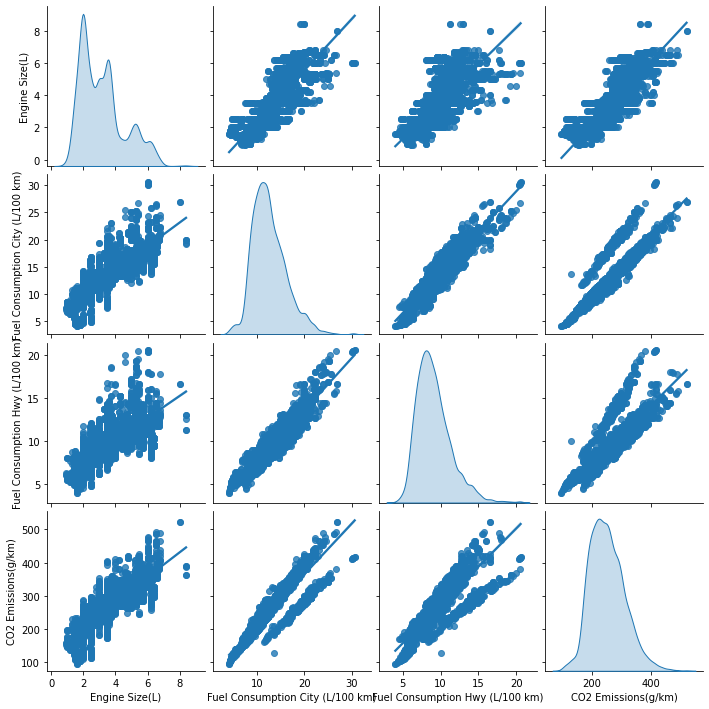

In [13]:
sns.pairplot(numeric_data, kind='reg', diag_kind='kde')

Observations
1. All variables are postiviely correlated to target
2. Except engine size everything else is normally distributed

## Categorical variables

In [132]:
df['Vehicle Class'].value_counts()

SUV - SMALL                 1006
MID-SIZE                     983
COMPACT                      903
SUV - STANDARD               613
SUBCOMPACT                   533
FULL-SIZE                    508
PICKUP TRUCK - STANDARD      475
TWO-SEATER                   381
MINICOMPACT                  274
STATION WAGON - SMALL        214
PICKUP TRUCK - SMALL         133
VAN - PASSENGER               66
SPECIAL PURPOSE VEHICLE       65
MINIVAN                       61
STATION WAGON - MID-SIZE      45
VAN - CARGO                   22
Name: Vehicle Class, dtype: int64

In [133]:
df['Cylinders'].value_counts()

4     2749
6     2040
8     1202
12     135
3       88
10      40
5       26
16       2
Name: Cylinders, dtype: int64

In [134]:
df['Transmission'].value_counts()

AS6     1139
AS8     1056
M6       773
A6       684
AM7      383
A8       378
AS7      283
A9       263
AV       241
M5       168
AS10     151
AM6      107
AV7       92
AV6       89
A5        78
M7        78
AS9       65
A4        61
AM8       45
A7        44
AV8       34
A10       28
AS5       26
AV10       9
AM5        4
AS4        2
AM9        1
Name: Transmission, dtype: int64

#### Observations
One of AV transmission has missing gears (around 241 rows). We will use imputer to fill the gears


```
A = Automatic
AM = Automated manual
AS = Automatic with select shift
AV = Continuously variable
M = Manual

Number represents the gears
```

#### Splitting this column into transmission mode and number of gears

In [135]:
df['TransmissionMode'] = df['Transmission'].apply(lambda x: re.search('[A-Z]*', x).group())

In [136]:
df['TransmissionMode'].value_counts()

AS    2722
A     1536
M     1019
AM     540
AV     465
Name: TransmissionMode, dtype: int64

In [137]:
# one of AV has no gears making it to 0 for now
df['Transmission'].replace({'AV':'AV0'}, inplace=True)

In [138]:
df['Gears'] = df['Transmission'].apply(lambda x: re.search('[0-9]+', x).group())

In [139]:
df['Gears'].value_counts()

6     2792
8     1513
7      880
9      329
5      276
0      241
10     188
4       63
Name: Gears, dtype: int64

In [140]:
df.drop(labels=['Transmission'], axis=1, inplace=True)

In [23]:
df['Fuel Type'].value_counts()

X    3039
Z    2765
E     330
D     147
N       1
Name: Fuel Type, dtype: int64

#### Removing Natural gas fuel since there is only one entry


In [24]:
df.drop(df[df['Fuel Type']=='N'].index, inplace=True)

In [25]:
df.reset_index(drop=True,inplace=True)
df

,Vehicle Class,Engine Size(L),Cylinders,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),CO2 Emissions(g/km),TransmissionMode,Gears
0,COMPACT,2.0,4,Z,9.9,6.7,196,AS,5
1,COMPACT,2.4,4,Z,11.2,7.7,221,M,6
2,COMPACT,1.5,4,Z,6.0,5.8,136,AV,7
3,SUV - SMALL,3.5,6,Z,12.7,9.1,255,AS,6
4,SUV - SMALL,3.5,6,Z,12.1,8.7,244,AS,6
...,...,...,...,...,...,...,...,...,...
6276,SUV - SMALL,2.0,4,Z,10.7,7.7,219,AS,8
6277,SUV - SMALL,2.0,4,Z,11.2,8.3,232,AS,8
6278,SUV - SMALL,2.0,4,Z,11.7,8.6,240,AS,8
6279,SUV - STANDARD,2.0,4,Z,11.2,8.3,232,AS,8


## Model Building And Selection

### First Model using LinearRegression

We are using sklearn [pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to build model.

1. Creating one hot encoder transformer to convert categorical to one hot encoded values.

2. Then passing data through KNN Imputer to treat missing values of gears

3. Pass through standard scaler for scaling date.

4. Pass through LinearRegression to find the coeficient and intercept


In [26]:
oneHotEncoder = make_column_transformer(
    (OneHotEncoder(sparse=False), ['Vehicle Class', 'Fuel Type', 'TransmissionMode']),
    remainder='passthrough'
)

In [113]:
pipe1 = make_pipeline(oneHotEncoder, KNNImputer(), StandardScaler(), LinearRegression())
pipe1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['Vehicle Class', 'Fuel Type',
                                                   'TransmissionMode'])])),
                ('knnimputer', KNNImputer()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [28]:
# Helper to get data from datafram
def get_data_1(df):
    frame = df.copy()
    y = frame['CO2 Emissions(g/km)']
    X = frame.drop(labels=['CO2 Emissions(g/km)'], axis=1)
    X['Cylinders'] = X['Cylinders'].astype('int')
    X['Gears'] = X['Gears'].astype('int')
    X['Gears'].replace({0:np.nan}, inplace=True)
    return X,y

1. Splitting data into test and train in 0.2 ratio
2. Fit the pipeline
3. r2 score of train and test data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(*get_data_1(df), test_size=0.2, random_state=42)
pipe1.fit(X_train, y_train)
r2_score(y_train, pipe1.predict(X_train)), r2_score(y_test, pipe1.predict(X_test))

(0.9918649049768482, 0.9921054799730065)

Draw box plots to see outliers

In [68]:
def draw_box_plots(df, cols):
    fig, axes = plt.subplots(int(np.ceil(len(cols)/3)),3, figsize=(15,8))
    axes = axes.ravel()
    for i, col in enumerate(cols):
        ax = axes[i]
        sns.boxplot(data=df, y = col, ax=ax)

In [31]:
outlier_cols = ['Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)','Engine Size(L)']

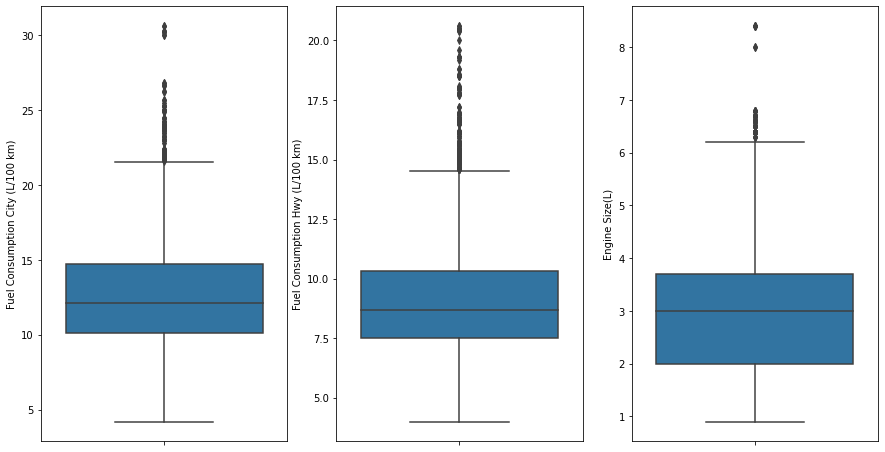

In [69]:
draw_box_plots(df, outlier_cols)

In [33]:
# helper to treat outliers
def treat_outliers(df, cols, factor = 1.5):
    frame = df.copy()
    for col in cols:
        series = frame[col]
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        smin = q1 - factor * iqr
        smax = q3 + factor * iqr
        frame.loc[series < smin, col] = smin
        frame.loc[series > smax, col] = smax
    return frame

1. Treat outliers with ratio of 1.5 IQR 
2. Splitting data into test and train in 0.2 ratio
3. Fit the pipeline
4. r2 score of train and test data

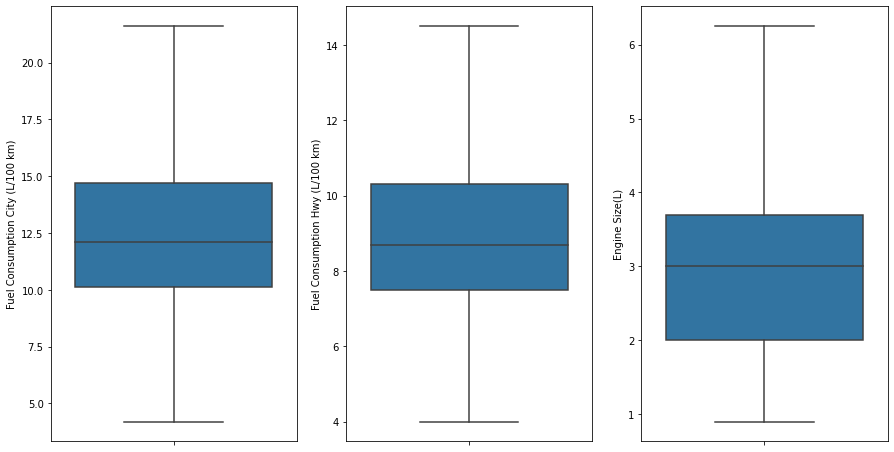

In [70]:
df_without_outliers = treat_outliers(df, outlier_cols)
draw_box_plots(df_without_outliers, outlier_cols)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(*get_data_1(df_without_outliers), test_size=0.2, random_state=42)
pipe1.fit(X_train, y_train)
r2_score(y_train, pipe1.predict(X_train)), r2_score(y_test, pipe1.predict(X_test))

(0.9905351624848721, 0.9891427732029083)

1. Treat outliers with ratio of 3 IQR 
2. Splitting data into test and train in 0.2 ratio
3. Fit the pipeline
4. r2 score of train and test data

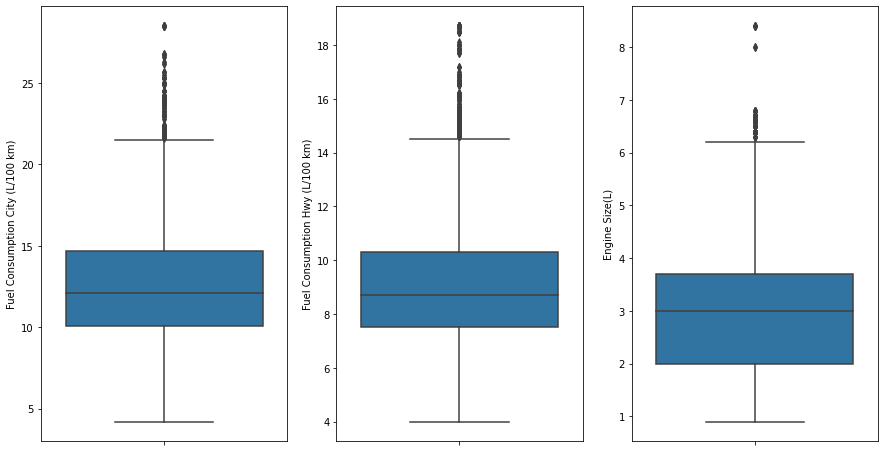

In [71]:
df_without_outliers_1 = treat_outliers(df, outlier_cols,3)
draw_box_plots(df_without_outliers_1, outlier_cols)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(*get_data_1(df_without_outliers_1), test_size=0.2, random_state=42)
pipe1.fit(X_train, y_train)
r2_score(y_train, pipe1.predict(X_train)), r2_score(y_test, pipe1.predict(X_test))

(0.993141715472525, 0.9931173786066354)

### Second Pipeline
Same as first pipeline with Forward Sequential Feature Selection with cross vaildation of 10 splits

In [114]:
pipe2 = make_pipeline(
    oneHotEncoder, 
    KNNImputer(), 
    StandardScaler(),
    SequentialFeatureSelector(LinearRegression(), n_features_to_select=15, scoring='r2', cv=10,),
    LinearRegression(),
)
pipe2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['Vehicle Class', 'Fuel Type',
                                                   'TransmissionMode'])])),
                ('knnimputer', KNNImputer()),
                ('standardscaler', StandardScaler()),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(cv=10, estimator=LinearRegression(),
                                           n_features_to_select=15,
                                           scoring='r2')),
                ('linearregression', LinearRegression())])

1. Splitting data into test and train in 0.2 ratio
2. Fit the pipeline
3. r2 score of train and test data

In [39]:
X_train, X_test, y_train, y_test = train_test_split(*get_data_1(df_without_outliers_1), test_size=0.2, random_state=42)
pipe2.fit(X_train, y_train)
r2_score(y_train, pipe2.predict(X_train)), r2_score(y_test, pipe2.predict(X_test))

(0.9931193059657089, 0.9930998524879353)

### Model 3

Same as above model replaced LinearRegression with SGD

In [40]:
pipe3 = make_pipeline(
    oneHotEncoder, 
    KNNImputer(), 
    StandardScaler(),
    SGDRegressor(
        loss='squared_loss', 
        alpha=0.0001, 
        max_iter=1000, 
        epsilon=0.1, 
        random_state=42, 
        early_stopping=True,
        validation_fraction = 0.001,
        verbose=0,
    ),
)
pipe3

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['Vehicle Class', 'Fuel Type',
                                                   'TransmissionMode'])])),
                ('knnimputer', KNNImputer()),
                ('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(early_stopping=True, random_state=42,
                              validation_fraction=0.001))])

1. Splitting data into test and train in 0.2 ratio
2. Fit the pipeline
3. r2 score of train and test data

In [41]:
X_train, X_test, y_train, y_test = train_test_split(*get_data_1(df_without_outliers_1), test_size=0.2, random_state=42)
pipe3.fit(X_train, y_train)
r2_score(y_train, pipe3.predict(X_train)), r2_score(y_test, pipe3.predict(X_test))

(0.9930132144194436, 0.993006524983319)

#### Pipeline 4 
same as pipeline 3 but used with GridSearch to select the number of features

In [42]:
pipe4 = Pipeline([
    ('encoding',oneHotEncoder), 
    ('imputer',KNNImputer()), 
    ('scaling',StandardScaler()),
    ('feature',SequentialFeatureSelector(LinearRegression(), scoring='r2', cv=5)),
    ('regression', SGDRegressor(
        loss='squared_loss', 
        alpha=0.0001, 
        max_iter=1000, 
        epsilon=0.1, 
        random_state=42, 
        early_stopping=True,
        validation_fraction = 0.001,
        verbose=0,
    )),
], verbose=False)
pipe4

Pipeline(steps=[('encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['Vehicle Class', 'Fuel Type',
                                                   'TransmissionMode'])])),
                ('imputer', KNNImputer()), ('scaling', StandardScaler()),
                ('feature',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           scoring='r2')),
                ('regression',
                 SGDRegressor(early_stopping=True, random_state=42,
                              validation_fraction=0.001))])

#### Model 4
Using grid search cv to find optimal number of features from (5, 27)

In [43]:
params = {
    'feature__n_features_to_select':list(range(5,27))
}
grid = GridSearchCV(pipe4, param_grid=params, scoring='r2', cv=5, verbose=5, n_jobs=4)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(*get_data_1(df_without_outliers_1), test_size=0.2, random_state=42)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['Vehicle '
                                                                          'Class',
                                                                          'Fuel '
                                                                          'Type',
                                                                          'TransmissionMode'])])),
                                       ('imputer', KNNImputer()),
                                       ('scaling', StandardScaler()),
                                       ('feature',
                                        SequentialFeatureSelector(estimator=LinearRegression(),
                                                                  scoring='r2')),
                                       ('regression',
                                        SGDRegressor(early_stopping=True,
                                                     random_state=42,
                                                     validation_fraction=0.001))]),
             n_jobs=4,
             param_grid={'feature__n_features_to_select': [5, 6, 7, 8, 9, 10,
                                                           11, 12, 13, 14, 15,
                                                           16, 17, 18, 19, 20,
                                                           21, 22, 23, 24, 25,
                                                           26]},
             scoring='r2', verbose=5)

In [45]:
r2_score(y_train, grid.predict(X_train)), r2_score(y_test, grid.predict(X_test))

(0.9929779555629832, 0.993043855639087)

In [46]:
# Helper to find r2 adjusted score
def r2_adjusted_score(r2, n, k):
  # 1 - (((1 - R-Squared) * (n - 1)) / (n - k - 1)
  return 1 - (((1 - r2) * (n - 1)) / (n - k - 1))

In [100]:
# Helper to find estimator and parameter grid results
def create_grid_result(grid):
  grid_result = pd.DataFrame(grid.cv_results_).drop(columns=['params'])
  grid_result['r2_adj_score'] = r2_adjusted_score(grid_result['mean_test_score'], len(X_train), grid_result['param_feature__n_features_to_select'])
  grid_result.sort_values(['r2_adj_score'], ascending=False, inplace=True)
  estimator = grid.best_estimator_
  selected_features = estimator.steps[3][1].get_support()
  columns = estimator.steps[0][1].get_feature_names()
  feature_df = pd.DataFrame({'selected':selected_features, 'features':columns})
  coef = pd.DataFrame({'coef': estimator[-1].coef_})
  intercept = estimator[-1].intercept_[0]
  return grid_result, coef.join(feature_df[feature_df['selected']].\
                        reset_index(drop=True)).\
                        drop(columns=['selected']).\
                        append({'coef':intercept, 'features':'_intercept'}, ignore_index=True).\
                        sort_values(['coef'], ascending=False)

In [101]:
grid_result, features = create_grid_result(grid)

Shows different attributes of grid search results

It is sorted by best r2 adjusted score value.

Observations
1. With 9 Features we are getting maximum accuracy of 0.992754 

In [102]:
grid_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature__n_features_to_select,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,r2_adj_score
4,16.240870,0.335700,0.386166,0.040857,9,0.992520,0.992514,0.994109,0.991442,0.993289,0.992775,0.000889,1,0.992762
3,13.778870,0.161554,0.372854,0.041545,8,0.992486,0.992144,0.994087,0.991302,0.993210,0.992646,0.000946,2,0.992634
1,9.780474,0.126297,0.368428,0.045416,6,0.992462,0.992053,0.993949,0.991101,0.993454,0.992604,0.001011,3,0.992595
2,11.870196,0.184546,0.365771,0.039677,7,0.992430,0.992123,0.994065,0.991268,0.993095,0.992596,0.000940,6,0.992586
5,18.206941,0.053726,0.389088,0.038941,10,0.992527,0.991592,0.994111,0.991500,0.993249,0.992596,0.000994,7,0.992581
17,50.376175,0.931234,0.438146,0.049965,22,0.991609,0.992656,0.994125,0.991414,0.993198,0.992600,0.001008,4,0.992568
16,48.188370,0.565258,0.437394,0.048548,21,0.991617,0.992638,0.994130,0.991412,0.993190,0.992598,0.001007,5,0.992567
13,41.171084,1.840505,0.424957,0.041775,18,0.991605,0.992650,0.993979,0.991400,0.993194,0.992566,0.000968,8,0.992539
14,40.927997,0.335892,0.423388,0.044928,19,0.991609,0.992643,0.993980,0.991400,0.993190,0.992564,0.000967,9,0.992536
10,30.314189,0.171657,0.402601,0.043298,15,0.991622,0.992633,0.994115,0.991394,0.992852,0.992523,0.000974,10,0.992501


#### Features

This table represents the featues selected and their coefficients

Observations

1. Fuel Consumption has highest coefficient
2. Fuel Type Methonol reduces C02 emissions since it has negative coeficient
3. Using Methonol we can reduce emission by 25
4. Intercept is 251.104

In [103]:
features

,coef,features
9,251.104489,_intercept
6,44.965753,Fuel Consumption City (L/100 km)
7,22.918521,Fuel Consumption Hwy (L/100 km)
4,4.347370,onehotencoder__x1_D
8,0.774746,Gears
1,0.436418,onehotencoder__x0_PICKUP TRUCK - SMALL
0,0.275594,onehotencoder__x0_FULL-SIZE
3,-0.678920,onehotencoder__x0_VAN - PASSENGER
2,-1.027355,onehotencoder__x0_VAN - CARGO
5,-25.440881,onehotencoder__x1_E


#### 5 The Final Model

1. Same as model 4 with one variation
2. Using Grid Search to combine Fuel Consumption City ang Hwy in different ratios to find optimal model


Creating a transformer which takes ratio and combines fuel usage

In [51]:
class CombineFuelConsumption(BaseEstimator, TransformerMixin):
  def __init__(self, ratio=0.5):
    self.ratio = ratio

  def fit(self, X, y = None):
    return self
  
  def transform(self, X, y = None):
    ratio = self.ratio
    computed = X['Fuel Consumption City (L/100 km)'] * ratio + X['Fuel Consumption Hwy (L/100 km)'] * (1-ratio)
    return np.array([computed]).reshape(-1,1)
 
  def get_feature_names(self):
    return ['Fuel Consumption']

In [52]:
combine_transformer = make_column_transformer(
    (OneHotEncoder(sparse=False), ['Vehicle Class', 'Fuel Type', 'TransmissionMode']),
    (CombineFuelConsumption(),['Fuel Consumption City (L/100 km)','Fuel Consumption Hwy (L/100 km)']),
    remainder='passthrough'
)

In [53]:
pipe5 = Pipeline(
    steps=[
      ('combine', combine_transformer), 
      ('imputer',KNNImputer()), 
      ('scaling',StandardScaler()),
      ('feature',SequentialFeatureSelector(LinearRegression(), scoring='r2', cv=5)),
      ('regression', SGDRegressor(
          loss='squared_loss', 
          alpha=0.0001, 
          max_iter=1000, 
          epsilon=0.1, 
          random_state=42, 
          early_stopping=True,
          validation_fraction = 0.001,
          verbose=0,
      )),
    ]
)
pipe5

Pipeline(steps=[('combine',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['Vehicle Class', 'Fuel Type',
                                                   'TransmissionMode']),
                                                 ('combinefuelconsumption',
                                                  CombineFuelConsumption(),
                                                  ['Fuel Consumption City '
                                                   '(L/100 km)',
                                                   'Fuel Consumption Hwy '
                                                   '(L/100 km)'])])),
                ('imputer', KNNImputer()), ('scaling', StandardScaler()),
                ('feature',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           scoring='r2')),
                ('regression',
                 SGDRegressor(early_stopping=True, random_state=42,
                              validation_fraction=0.001))])

Training Model and finding r2 scores for pipeline

In [54]:
X_train, X_test, y_train, y_test = train_test_split(*get_data_1(df_without_outliers_1), test_size=0.2, random_state=42)
pipe5.fit(X_train, y_train)
r2_score(y_train, pipe5.predict(X_train)), r2_score(y_test, pipe5.predict(X_test))

(0.9926911383261665, 0.9927825235405848)

#### Model 5

Creaing a grid of 
1. Fuel Usage ratio in 0.5 - 0.7 splitting into range of 10 
2. Features (5,20)

In [55]:
params = {
    'combine__combinefuelconsumption__ratio':list(np.linspace(0.5, 0.7, 10)),
    'feature__n_features_to_select':list(range(5,20)),
}
grid2 = GridSearchCV(pipe5, param_grid=params, scoring='r2', cv=5, verbose=5, n_jobs=-1)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(*get_data_1(df_without_outliers_1), test_size=0.2, random_state=42)
grid2.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('combine',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['Vehicle '
                                                                          'Class',
                                                                          'Fuel '
                                                                          'Type',
                                                                          'TransmissionMode']),
                                                                        ('combinefuelconsumption',
                                                                         CombineFuelConsumption(),
                                                                         ['Fuel '
                                                                          'Consumption '
                                                                          'City '
                                                                          '(L/100 '
                                                                          'km)',
                                                                          'Fuel '
                                                                          'Consumption '
                                                                          'Hwy '
                                                                          '(L/100 '
                                                                          'km)'])])),
                                       ('impute...
                                                     validation_fraction=0.001))]),
             n_jobs=-1,
             param_grid={'combine__combinefuelconsumption__ratio': [0.5,
                                                                    0.5222222222222223,
                                                                    0.5444444444444444,
                                                                    0.5666666666666667,
                                                                    0.5888888888888889,
                                                                    0.611111111111111,
                                                                    0.6333333333333333,
                                                                    0.6555555555555554,
                                                                    0.6777777777777777,
                                                                    0.7],
                         'feature__n_features_to_select': [5, 6, 7, 8, 9, 10,
                                                           11, 12, 13, 14, 15,
                                                           16, 17, 18, 19]},
             scoring='r2', verbose=5)

r2 score of model 5

In [57]:
r2_score(y_train, grid2.predict(X_train)), r2_score(y_test, grid2.predict(X_test))

(0.9929449433695127, 0.9929500562290614)

In [104]:
grid_result, features = create_grid_result(grid2)

#### Results of Model 5
1. Number of features selected 16
2. Ratio of fuel 0.54444
3. Max adjusted r2 score 0.9928

In [105]:
grid_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_combine__combinefuelconsumption__ratio,param_feature__n_features_to_select,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,r2_adj_score
36,21.510665,0.394025,0.417041,0.041645,0.544444,11,0.992613,0.992663,0.993743,0.991613,0.993152,0.992757,0.000702,2,0.992741
88,39.752895,0.694147,0.435333,0.041076,0.611111,18,0.992179,0.992481,0.994223,0.991880,0.993035,0.992760,0.000825,1,0.992734
48,15.158726,0.410214,0.420485,0.042216,0.566667,8,0.992765,0.992512,0.994046,0.991297,0.993008,0.992726,0.000885,4,0.992714
55,30.918502,0.365655,0.417838,0.045484,0.566667,15,0.992068,0.992696,0.994216,0.991452,0.993196,0.992726,0.000949,3,0.992704
56,33.242639,0.548706,0.417278,0.040822,0.566667,16,0.992046,0.992697,0.994222,0.991451,0.993196,0.992722,0.000954,5,0.992699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,11.061552,0.238994,0.424352,0.042835,0.677778,6,0.991446,0.990809,0.993241,0.990355,0.992104,0.991591,0.001015,146,0.991581
120,9.089696,0.172397,0.424713,0.045935,0.677778,5,0.991266,0.990551,0.993116,0.990315,0.992061,0.991462,0.001028,147,0.991453
137,13.016858,0.276367,0.424723,0.044222,0.7,7,0.991420,0.990794,0.993077,0.990189,0.991768,0.991450,0.000976,148,0.991438
136,11.031789,0.152706,0.423443,0.047282,0.7,6,0.991291,0.990473,0.992915,0.990011,0.991708,0.991279,0.001012,149,0.991269


#### Features
1. Fuel consumption has high impact
2. Using Ethonol reduces CO2 Emission
3. Intercept is 251.075825

In [106]:
features

,coef,features
18,251.075825,_intercept
15,65.375685,combinefuelconsumption__Fuel Consumption
10,4.115495,onehotencoder__x1_D
3,0.947204,onehotencoder__x0_PICKUP TRUCK - STANDARD
6,0.869670,onehotencoder__x0_SUV - SMALL
2,0.833038,onehotencoder__x0_PICKUP TRUCK - SMALL
16,0.765236,Cylinders
17,0.700386,Gears
7,0.591428,onehotencoder__x0_SUV - STANDARD
4,0.473106,onehotencoder__x0_SPECIAL PURPOSE VEHICLE


### Model Performance and Metrics

In [61]:
# Find mean absolute percentage error
def mape(actual, predicted):
    return (np.mean(np.abs((actual - predicted) / actual)) * 100)

In [62]:
# Shapiro test on normality of residuals
def find_normality(y_true, y_pred):
  statistic, pvalue = stats.shapiro(y_true - y_pred)
  return np.round(pvalue, 4)

In [63]:
# F value to find if the model has any significance
def find_f_value(y_true, y_pred, k):
  n = len(y_true)
  r2 = r2_score(y_true, y_pred)
  f_value = (r2 / (k - 1))/((1-r2)/(n - k))
  dfn = k - 1
  dfd = n - k
  return np.round(stats.f.sf(f_value, dfn = dfn, dfd = dfd), 4)

In [64]:
# List of all models
all_models = {
    'pipe 1': {
        'model':pipe1,
        'data':  train_test_split(*get_data_1(df), test_size=0.2, random_state=42),
        'k': 30,
    },
    'pipe 2': {
        'model': pipe2,
        'data':  train_test_split(*get_data_1(df_without_outliers), test_size=0.2, random_state=42),
        'k': 30,
    },
    'pipe 3': {
        'model': pipe3,
        'data':  train_test_split(*get_data_1(df_without_outliers_1), test_size=0.2, random_state=42),
        'k': 30,
    },
    'grid': {
        'model': grid,
        'data':  train_test_split(*get_data_1(df_without_outliers_1), test_size=0.2, random_state=42),
        'k': 9,
    },
    'grid 2': {
        'model': grid2,
        'data':  train_test_split(*get_data_1(df_without_outliers_1), test_size=0.2, random_state=42),
        'k': 15
    },
}

In [65]:
# Helper to get all metrics
def get_metrics(all_models):
  metrics = {
      'model':[],
      'r2 train':[],
      'r2 test':[],
      'adjusted r2 train':[],
      'adjusted r2 test':[],
      'mse train':[],
      'mse test':[],
      'rmse train':[],
      'rmse test':[],
      'mae test':[],
      'mae train':[],
      'mape train':[],
      'mape test':[],
      'shaphiro train':[],
      'shaphiro test':[],
      'f value train':[],
      'f value test':[]
  }
  for i, key in enumerate(all_models):
    metrics['model'].append(key)
    modelObj = all_models[key]
    model = modelObj['model']
    X_train, X_test, y_train, y_test = modelObj['data']
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    metrics['r2 train'].append(r2_score(y_train, y_train_pred))
    metrics['r2 test'].append(r2_score(y_test, y_test_pred))
    
    metrics['adjusted r2 train'].append(r2_adjusted_score(r2_score(y_train, y_train_pred), len(y_train), modelObj['k']))
    metrics['adjusted r2 test'].append(r2_adjusted_score(r2_score(y_test, y_test_pred), len(y_train), modelObj['k']))
    
    metrics['mse train'].append(mean_squared_error(y_train, y_train_pred))
    metrics['mse test'].append(mean_squared_error(y_test, y_test_pred))
    
    metrics['rmse train'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    metrics['rmse test'].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    
    metrics['mae train'].append(mean_absolute_error(y_train, y_train_pred))
    metrics['mae test'].append(mean_absolute_error(y_test, y_test_pred))
    
    metrics['mape train'].append(mape(y_train, y_train_pred))
    metrics['mape test'].append(mape(y_test, y_test_pred))

    metrics['shaphiro train'].append(find_normality(y_train, y_train_pred))
    metrics['shaphiro test'].append(find_normality(y_test, y_test_pred))

    metrics['f value train'].append(find_f_value(y_train, y_train_pred, modelObj['k']))
    metrics['f value test'].append(find_f_value(y_test, y_test_pred, modelObj['k']))
    
  result = pd.DataFrame(metrics)
  return result.sort_values('adjusted r2 test', ascending=False).reset_index(drop=True)

Observations

1. Model 4 has highest r2 adjusted score on test data 0.993032
2. Since p value of f statistic for all models is less than 0.05 all models are significant
3. Since shapiro values of models are less than 0.05 residuals are not normally distributed  

In [66]:
get_metrics(all_models)

,model,r2 train,r2 test,adjusted r2 train,adjusted r2 test,mse train,mse test,rmse train,rmse test,mae test,mae train,mape train,mape test,shaphiro train,shaphiro test,f value train,f value test
0,grid,0.992978,0.993044,0.992965,0.993031,24.428531,25.460278,4.942523,5.045818,2.946923,2.900356,1.149979,1.197176,0.0,0.0,0.0,0.0
1,pipe 3,0.993013,0.993007,0.992971,0.992965,24.305871,25.596912,4.930099,5.059339,2.969686,2.917279,1.168607,1.216169,0.0,0.0,0.0,0.0
2,grid 2,0.992945,0.992950,0.992924,0.992929,24.543375,25.803594,4.954127,5.079724,3.077614,3.027108,1.216380,1.260381,0.0,0.0,0.0,0.0
3,pipe 1,0.991740,0.992084,0.991690,0.992036,28.736370,28.974974,5.360632,5.382841,3.018645,2.966749,1.170686,1.220756,0.0,0.0,0.0,0.0
4,pipe 2,0.984362,0.984766,0.984268,0.984674,54.403706,55.758287,7.375887,7.467147,3.377887,3.235358,1.228183,1.296401,0.0,0.0,0.0,0.0


We are choosing Model 5 since it has highest performance and saving it to file and deploying to cloud

1. We used GCloud Run for deploying the dockerized model on serverless architecture and exposed REST API.

2. We used React as client or frontend and deployed in firebase hosting.

# Equation to compute CO2 Emission

$$
\hat{y} = \beta_{0} + Fuel Consumption City \times \beta_{1} + Fuel Consumption Hwy \times \beta_{2} + Fuel Diesel \times \beta_{3} + Gears \times \beta_{4} + Pickup truck small \times \beta_{5} + Full size \times \beta_{6} + Van passenger \times \beta_{7}
+ Van cargo \times \beta_{8} + Fuel Ethanol \times \beta_{9}
$$

Where :- 

$ \beta_{0} = 251.104489 $

$ \beta_{1} = 44.965753 $

$ \beta_{2} = 22.918521 $

$ \beta_{3} = 4.347370 $

$ \beta_{4} = 0.774746 $

$ \beta_{5} = 0.436418 $

$ \beta_{6} = 0.275594 $

$ \beta_{7} = -0.678920 $

$ \beta_{8} = -1.027355 $

$ \beta_{9} = -25.440881 $

<br/>
<br/>

$$
\hat{y} = 251.104489 + Fuel Consumption City \times 44.965753 + Fuel Consumption Hwy \times 22.918521 + Fuel Diesel \times 4.347370 + Gears \times 0.774746 + Pickup truck small \times 0.436418  + Full size \times  0.275594 + Van passenger \times (-0.678920)
+ Van cargo \times (-1.027355) + Fuel Ethanol \times (-25.440881)
$$ 


In [107]:
joblib.dump(grid, '../models/model.m5')

['../models/model.m5']

[Link to website](https://co2-prediction.web.app)

[Link to github](https://github.com/Deepak13245/fuel-co2-regression)

<big><big><big><center>Thank You</center></big></big></big><br/>
<big><big><big><center style="font-size: 48px;">☺</center></big></big></big>

## References

https://co2-prediction.web.app/

https://github.com/Deepak13245/fuel-co2-regression

https://www.kaggle.com/debajyotipodder/co2-emission-by-vehicles

https://pandas.pydata.org/

https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://flask.palletsprojects.com/en/1.1.x/

https://flask-cors.readthedocs.io/en/latest/index.html

https://firebase.google.com/docs/hosting

https://www.docker.com/

https://martinfowler.com/articles/serverless.html

https://cloud.google.com/run

https://cloud.google.com/build

https://cloud.google.com/artifact-registry

https://reactjs.org/


https://www.youtube.com/watch?v=t5EfITuFD9w

https://www.youtube.com/watch?v=DxVuO9gqotk





